# Imports

In [34]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# Dataset

In [35]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

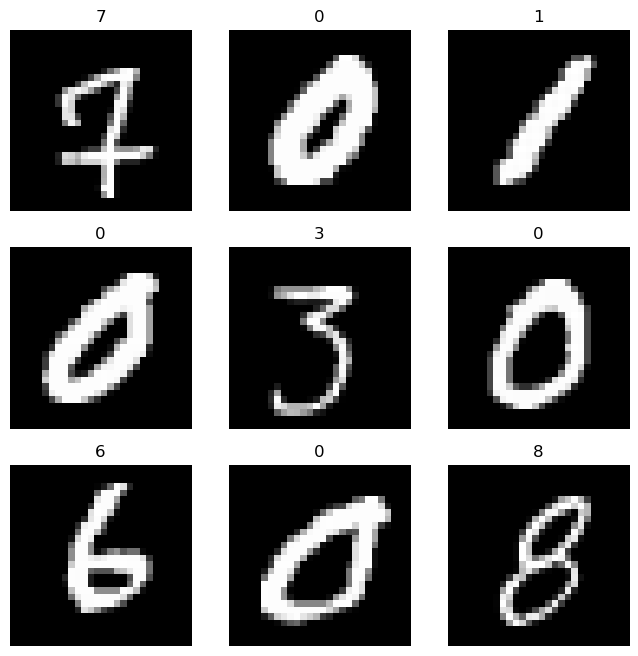

In [36]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [37]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Miscellaneous

In [38]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(f"Using {device} device")

Using cuda device


# Classifier

In [39]:
# Define model
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        # loss and optimizer
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters()) # TODO il se passe quoi si je mets cette ligne avant le sequential ?

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

classifier = Classifier().to(device)
print(classifier)

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
  (loss_function): CrossEntropyLoss()
)


# Identity Transformer

In [105]:
a = torch.tensor([[1,2,3], [4,5,6]])
n = 3
b = torch.tile(a, (n,))
c = a.repeat_interleave(n, dim=-1)
print(b)
print(c)
print(a)


tensor([[1, 2, 3, 1, 2, 3, 1, 2, 3],
        [4, 5, 6, 4, 5, 6, 4, 5, 6]])
tensor([[1, 1, 1, 2, 2, 2, 3, 3, 3],
        [4, 4, 4, 5, 5, 5, 6, 6, 6]])
tensor([[1, 2, 3],
        [4, 5, 6]])


In [40]:
class IdentityTransformer(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # https://stackoverflow.com/questions/60908827/why-pytorch-nn-module-cuda-not-moving-module-tensor-but-only-parameters-and-bu
        self.positional_encoding = nn.Parameter(torch.rand((28), requires_grad=True)) # TODO see if requires_grad=True is needed here
        self.flatten = nn.Flatten()
        self.transformer = nn.Transformer(
            d_model=28, 
            nhead=1, 
            num_encoder_layers=3, 
            num_decoder_layers=3, 
            batch_first=True) # https://discuss.pytorch.org/t/why-is-sequence-batch-features-the-default-instead-of-bxsxf/8244

    def forward(self, input):
        """Takes a batch of 28*28 pictures (N,28,28) # TODO verifier que c'est pas (N,1,28,28) que donne le dataloader
        We want to have (N,S,E)=(N,28,28), i.e. each row is a 'token' and the whole picture is a sentence."""
        input = torch.add(input, self.positional_encoding) # picture += positional encoding
        # input = self.flatten(input) # (N,28,28) -> (N,784)
        # input = torch.unsqueeze(input, 2) # (N,784) -> (N,784,1)
        input = torch.squeeze(input) # TODO lié au TODO d'en haut (N,1,28,28)->(N,28,28)
        output = self.transformer(input, input)
        # output = torch.reshape(output, input.shape) # (N,1,784) -> (N,28,28)
        return output

identity_transformer = IdentityTransformer().to(device)

# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(identity_transformer.parameters(), lr=1e-4) # TODO train learning rate during training phase r adjust it 
# https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

IdentityTransformer(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=28, out_features=28, bias=True)
          )
          (linear1): Linear(in_features=28, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=28, bias=True)
          (norm1): LayerNorm((28,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((28,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=28, out_features=28, bias=True)
         

# Autoencoder

In [45]:
class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dim: int = 2) -> None:
        super().__init__()
        self.encoder = IdentityTransformer()
        self.decoder = IdentityTransformer()
        self.flatten = nn.Flatten()
        self.bottleneck = nn.Sequential(nn.Linear(28*28, bottleneck_dim), nn.Linear(2, 28*28))
        
    def forward(self, input):
        x = self.encoder(input)
        x = torch.reshape(self.bottleneck(self.flatten(x)), x.shape)
        output = self.decoder(x)
        return output
        
autoencoder = Autoencoder().to(device)
print(autoencoder)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

Autoencoder(
  (encoder): IdentityTransformer(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=28, out_features=28, bias=True)
            )
            (linear1): Linear(in_features=28, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=28, bias=True)
            (norm1): LayerNorm((28,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((28,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantiz

# Train

In [42]:
def train_autoencoder(dataloader, model, loss_function, optimizer):
    """Right now, when iterated over, the dataloader returns a data point AND a label. 
    TODO faire en sorte que le dataloader soit composé que des images, sans les labels."""

    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_function(pred, X.squeeze()) # TODO remove need of squeeze cleanly in dataloader

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_autoencoder(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_function(pred, X.squeeze()).item() # TODO remove need of squeeze cleanly in dataloader
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

# ---

In [48]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_autoencoder(train_dataloader, autoencoder, loss_function, optimizer)
    test_autoencoder(test_dataloader, autoencoder, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 0.555056  [    0/60000]
loss: 0.523574  [ 6400/60000]
loss: 0.512720  [12800/60000]
loss: 0.474544  [19200/60000]
loss: 0.451292  [25600/60000]
loss: 0.424840  [32000/60000]
loss: 0.404851  [38400/60000]
loss: 0.391950  [44800/60000]
loss: 0.368625  [51200/60000]
loss: 0.356896  [57600/60000]
Test Error: Avg loss: 0.336709 

Epoch 2
-------------------------------
loss: 0.341222  [    0/60000]
loss: 0.322724  [ 6400/60000]
loss: 0.316554  [12800/60000]
loss: 0.302100  [19200/60000]
loss: 0.279573  [25600/60000]
loss: 0.265096  [32000/60000]
loss: 0.248233  [38400/60000]
loss: 0.239174  [44800/60000]
loss: 0.229226  [51200/60000]
loss: 0.219221  [57600/60000]
Test Error: Avg loss: 0.205662 

Epoch 3
-------------------------------
loss: 0.208492  [    0/60000]
loss: 0.197327  [ 6400/60000]
loss: 0.191578  [12800/60000]
loss: 0.191455  [19200/60000]
loss: 0.170248  [25600/60000]
loss: 0.163641  [32000/60000]
loss: 0.150891  [38400/60000]
loss

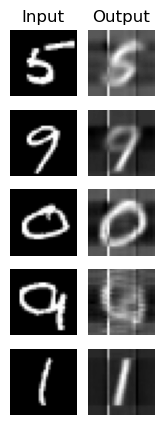

In [57]:
n = 5
fig, axs = plt.subplots(n, 2, figsize=(2,5))
for i in range(n):
    # Input
    random_index = np.random.randint(len(test_data))
    img, label = test_data[random_index]
    ax = axs[i, 0]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis("off")
    if i == 0: ax.set_title('Input')

    # Output
    # output_image = autoencoder(torch.unsqueeze(img, 0).to(device))
    input = torch.unsqueeze(img, 0).to(device)
    x = autoencoder.encoder(input)
    x = torch.reshape(autoencoder.bottleneck(torch.flatten(x)), x.shape)
    output_image = autoencoder.decoder(x)

    ax = axs[i, 1]
    ax.imshow(output_image.cpu().detach().numpy().squeeze(), cmap="gray")
    ax.axis("off")
    if i == 0: ax.set_title('Output')
plt.subplots_adjust(wspace=0.0)
plt.show()

TODO : faire un cahier de bord
Dire que j'ai voulu faire l'autoencodeur, et je me suis dit "et pourquoi pas faire avec des transformers ?"
Comme je maîtrisais pas bien nn.Transformer, j'ai voulu d'abord faire juste un réseau transformer qui en lui donnant une image ressors la même image (la fonction identité donc). Mais comme les transformers ça prend des phrases et des mots, faut réfléchir ce qui est quoi.
On peut essayer (avec les default values pour le transformer, l'optimizer, etc):
- 1 image = 1 phrase/sequence
    - 1 ligne = 1 mot/token, chaque mot (ligne) est de dimension 28 et il y a 28 mots dans la phrase (image)
    - 1 pixel = 1 mot, chaque mot (pixel) est de dimension 1 et il y a 28*28 mots dans la phrase (image)